In [34]:
%matplotlib inline
import numpy as np
import os
import pickle 

# Expected shape is 1175 Trials x 13 channels x 15000 samples (@ 5000Hz) - value is potential
raw_source_dir = "median_labelled/"

# files = ['x1_long', 'x2_long', 'y_median_per_recording']
# files = ['x_train.pickle', 'y_train.pickle', 'x_test.pickle', 'y_test.pickle']
files = ['x', 'y_median_per_recording']
file_data = []
for i, fn in enumerate(files):
    with open(os.path.join(raw_source_dir, '{}.pickle'.format(fn)), 'rb') as f:
        file_data.append(np.array(pickle.load(f)))
        
# x_train = file_data[0]
# y_train = file_data[1]
# x_test = file_data[2] 
# y_test = file_data[3]
# print(x_train.shape)
# print(y_train.shape)

# Trim to 1 second -> 5000
# x1 = file_data[0][...,:5000]
# x2 = file_data[1][...,:5000]
# y = file_data[2]
x = file_data[0]
y = file_data[1]
# x = np.concatenate((x1, x2)
# pickle_name = "x.pickle".format()
# with open(pickle_name, "wb") as pf:
#     pickle.dump(x, pf)


In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
seed = 1
np.random.seed(seed)

In [77]:
# Referencing http://forrestbao.blogspot.com/2009/10/eeg-signal-processing-in-python-and.html
# And https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

# Sliding window spectrogram

def create_spectrogram(eeg_signal, save_name):
    # Shape trials x channels x samples
    fs = 5000.0

    # Create windows
    sample_length = eeg_signal.shape[-1]
    
    
    # Hyperparams
    window_length = 2500 # Expected frequency resolution of 2Hz
    step_size = 50
    banded_freq = 100 # 200Hz 
    
    roll_cap = (sample_length - window_length)//step_size + 1 # Number of windows
    roll_ctr = 0

    # Prepare fft
    # f = np.linspace(0,fs, window_length) # 5000/625 -> resolution of about 8Hz...

    fft_over_time = np.zeros((eeg_signal.shape[0], eeg_signal.shape[1], roll_cap, banded_freq))

    # Could consider vectorizing...
    while roll_ctr < roll_cap:
        window_sample = eeg_signal[...,roll_ctr * step_size: roll_ctr * step_size + window_length]
        fft_over_time[..., roll_ctr,:] = np.abs(np.fft.rfft(window_sample)[...,:banded_freq]) / window_length # fft over whole time frame
        roll_ctr += 1
    with open(save_name, "wb") as pf:
        pickle.dump(fft_over_time, pf)
    print("Done pickling {}".format(save_name))
    return fft_over_time
    

In [78]:
# Sanity check
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 5000)
s = t * np.sin(20 * 2 * np.pi * t) + 0.5 * np.sin(10 * 2 * np.pi * t)



signal = np.asarray([[s]]) # Simulate 1 trial, 1 channel
print(signal.shape)

(1, 1, 5000)


Done pickling test_fft.pickle


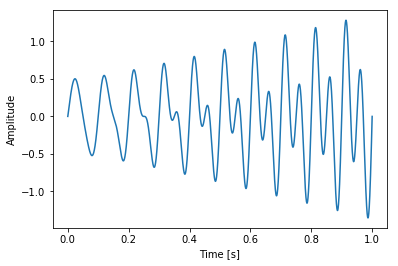

In [72]:
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
test_fft = create_spectrogram(signal, 'test_fft.pickle')

In [73]:
# What we expect is a continuous power at 20Hz (10th index), 0 for the others
print(test_fft.shape)
# window (related to time) and frequencies at window (plot on 2d)

(1, 1, 51, 20)


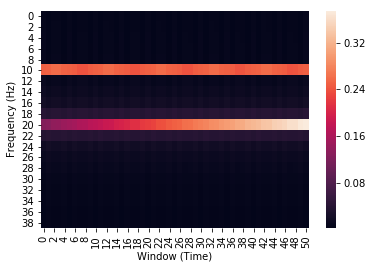

In [74]:
import seaborn as sns
resolution = 2
spectro = test_fft[0,0].T
ax = sns.heatmap(spectro, yticklabels=np.arange(spectro.shape[0])*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

In [79]:
x_fft = create_spectrogram(x, 'x_fft.pickle')
# x_fft = pickle.load('x_fft.pickle')
print(x.shape)


Done pickling x_fft.pickle
(1452, 13, 5000)


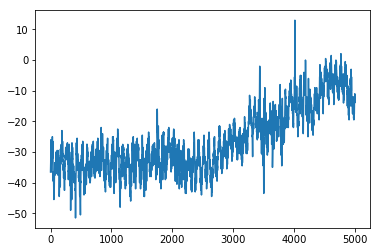

In [80]:
plt.plot(x[0,0])

In [81]:
print(x.shape)
print(x_fft.shape)
x_flattened = x_fft[:,:3].reshape((x_fft.shape[0], -1))

(1452, 13, 5000)
(1452, 13, 51, 100)


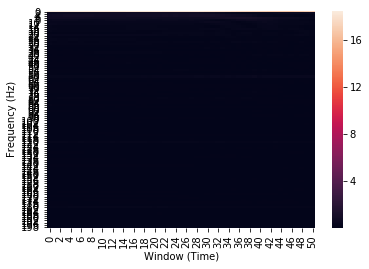

[[1.84938000e+01 5.39717807e-01 7.83831653e-01 ... 2.37968262e-02
  2.65913247e-02 4.54438683e-02]
 [1.84356000e+01 5.56007325e-01 8.31166477e-01 ... 2.72014330e-02
  2.39502318e-02 4.90045146e-02]
 [1.83832000e+01 5.81517359e-01 8.66031985e-01 ... 1.62761189e-02
  3.20580097e-02 4.05670427e-02]
 ...
 [1.68706000e+01 4.40878193e-01 6.32892847e-02 ... 4.05195332e-02
  2.48829364e-02 3.36940503e-02]
 [1.69996000e+01 4.72882479e-01 1.44237624e-01 ... 4.19899265e-02
  2.32314438e-02 3.35509166e-02]
 [1.70776000e+01 5.14844679e-01 2.10395700e-01 ... 3.70601051e-02
  3.08205246e-02 2.90607124e-02]]


In [82]:
resolution = 2
spectro = x_fft[100,0].T
ax = sns.heatmap(spectro, yticklabels=np.arange(spectro.shape[0])*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

print(x_fft[100, 0])

In [26]:
x_tr, x_te, y_tr, y_te = train_test_split(x_flattened, y[:-1], test_size=.2, random_state=seed)


In [27]:
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
clf = SVC()
clf.fit(x_tr, y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:

scores = cross_val_score(clf, x_flattened, y[:-1], cv=5)
print(scores)


[0.51890034 0.49828179 0.50689655 0.5137931  0.5137931 ]


In [32]:
from sklearn.metrics import accuracy_score
predict = clf.predict(x_te)
u, counts = np.unique(y, return_counts=True)
print(counts)
print(predict[:10])
print(accuracy_score(predict, y_te))

[731 722]
[1 1 1 1 1 1 1 1 1 1]
0.5051546391752577
